In [2]:
import datetime
import pickle
import random
import time
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Input, Embedding, Dropout, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
TRAIN_DATA_PATH = 'drive/MyDrive/COMP 576 Final Project/train_Data.csv'
TEST_DATA_PATH = 'drive/MyDrive/COMP 576 Final Project/test_Data.csv'
CV_DATA_PATH = 'drive/MyDrive/COMP 576 Final Project/cv_Data.csv'
PAD_SIZE = 167
BATCH_SIZE = 14
train_dataset = pd.read_csv(TRAIN_DATA_PATH)
test_dataset = pd.read_csv(TEST_DATA_PATH)
cv_dataset = pd.read_csv(CV_DATA_PATH)

In [4]:
X_train, X_test, X_cv = train_dataset['Person_id'], test_dataset['Person_id'], cv_dataset['Person_id']
y_train, y_test, y_cv = train_dataset['Report'], test_dataset['Report'], cv_dataset['Report']

In [5]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)
VOCAB_SIZE = len(tokenizer.word_index.keys()) + 1

In [6]:
IMG_FEATURES_ENC_DEC_FILE_PATH = 'drive/MyDrive/COMP 576 Final Project/Image_Features_Enc_Dec.pickle'
image_features = {}
with open(IMG_FEATURES_ENC_DEC_FILE_PATH, 'rb') as file:
    image_features = pickle.load(file)

In [7]:
word_to_idx_map = tokenizer.word_index


In [8]:
def load_image(uid, report):
    img_feature = image_features[uid.decode('utf-8')][0]
    return img_feature, report

In [9]:
def get_dataset_generator(img_uid, report):
    dataset = tf.data.Dataset.from_tensor_slices((img_uid, report))
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
train_dataset = get_dataset_generator(X_train, y_train)
cv_dataset = get_dataset_generator(X_cv, y_cv)

In [11]:
def bytes_to_string(bytes):
    return [byte.decode('utf-8') for byte in bytes]

In [12]:
def convert(images, reports):
    img_vectors = []
    inp_report_seq = []
    pred_report_seq = []
    for i in range(len(images)):
        sequence = [word_to_idx_map[word] for word in reports[i].split() if word in word_to_idx_map.keys()]
        for j in range(1,len(sequence)):
            inp_seq = sequence[:j]
            pred_seq = sequence[j]
            pred_cat_seq = tf.keras.utils.to_categorical(pred_seq, num_classes=VOCAB_SIZE)
            img_vectors.append(images[i])
            inp_report_seq.append(inp_seq)
            pred_report_seq.append(pred_cat_seq)
    inp_report_seq = pad_sequences(inp_report_seq, maxlen=PAD_SIZE, padding='post')
    return np.array(img_vectors), np.array(inp_report_seq), np.array(pred_report_seq)

In [13]:
np.random.seed(42)
tf.random.set_seed(32)
random.seed(12)

In [14]:
input1 = Input(shape=(2048), name='Image_Input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='Encoded_Image')(input1)

input2 = Input(shape=(PAD_SIZE), name='Report_Input')
emb_layer = Embedding(input_dim = VOCAB_SIZE, output_dim = 300, input_length=PAD_SIZE, mask_zero=True, trainable=False,
                name="Embedding_Layer")
emb = emb_layer(input2)

LSTM1 = GRU(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="GRU1")(emb)

LSTM2 = GRU(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="GRU2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='Dropout')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=63), name='FC1')
fc1_output = fc1(dec)
output_layer = Dense(VOCAB_SIZE, activation='softmax', name='Final_Output')
output = output_layer(fc1_output)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Report_Input (InputLayer)   [(None, 167)]                0         []                            
                                                                                                  
 Embedding_Layer (Embedding  (None, 167, 300)             592800    ['Report_Input[0][0]']        
 )                                                                                                
                                                                                                  
 GRU1 (GRU)                  (None, 167, 256)             428544    ['Embedding_Layer[0][0]']     
                                                                                                  
 Image_Input (InputLayer)    [(None, 2048)]               0         []                        

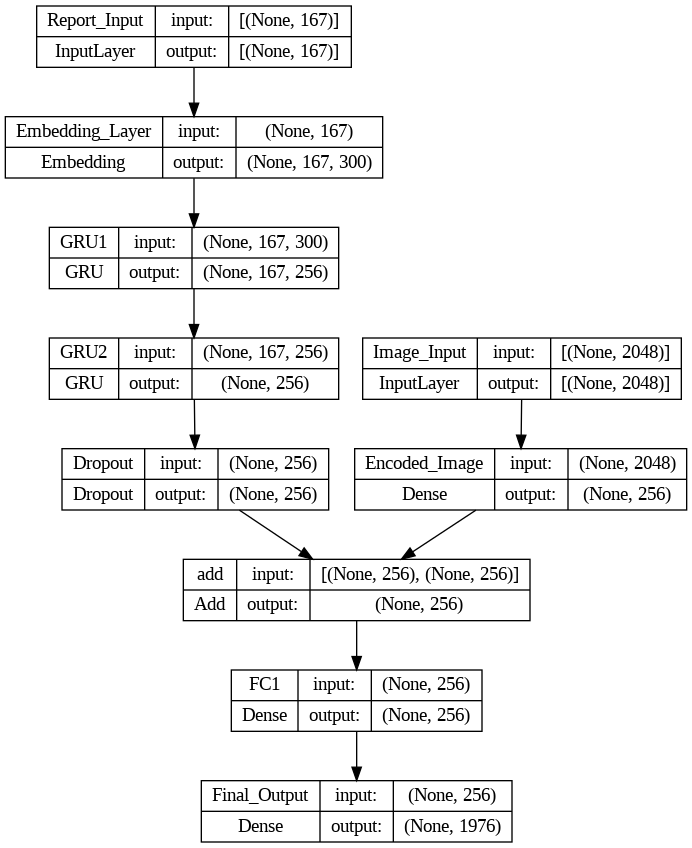

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(encoder_decoder, show_shapes=True, show_layer_names=True)

In [16]:
optimizer = tf.keras.optimizers.legacy.Adam(0.001)

In [17]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')
def get_final_masked_loss(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss = loss_function(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = loss * mask
    final_loss = tf.reduce_mean(loss)
    return final_loss

In [18]:
encoder_decoder.compile(optimizer, loss=get_final_masked_loss)

In [46]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TRAIN_LOG_DIR = 'Tensorboard/logs/' + current_time + '/train'
VAL_LOG_DIR = 'Tensorboard/logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(TRAIN_LOG_DIR)
val_summary_writer = tf.summary.create_file_writer(VAL_LOG_DIR)
WEIGHTS_TO_SAVE_DIR = "data/"
EPOCHS = 40

In [40]:
%cd data

/content/drive/MyDrive/COMP 576 Final Project/data


In [45]:
%ls

 brucechou1983_CheXNet_Keras_0.3.0_weights.h5  'ecgen-radiology (1)'/            Image-Report.csv
 ChexNet_Enc_Dec.ipynb                         'EDA and Cleaning.ipynb'         'Scanned Images'@
 cv_Data.csv                                   'Encoder_Decoder_Mod (1).ipynb'   Tensorboard/
 data/                                          glove.42B.300d.txt               test_Data.csv
 ecgen-radiology@                               Image_Features_Enc_Dec.pickle    train_Data.csv


# Training for epochs 1-20

In [ ]:
epoch_train_loss = []
epoch_val_loss = []

def calculate_loss(img, report):
    report_in_str = bytes_to_string(report.numpy())
    img_input, rep_input, pred_output = convert(img.numpy(), report_in_str)
    result = encoder_decoder.train_on_batch([img_input, rep_input], pred_output)
    return result

for epoch in range(EPOCHS):
    print('EPOCH : ', epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0

    for img, report in train_dataset:
        batch_loss_tr += calculate_loss(img, report)

    train_loss = batch_loss_tr/(X_train.shape[0]//BATCH_SIZE)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)

    for img, report in cv_dataset:
        batch_loss_vl += calculate_loss(img, report)

    val_loss = batch_loss_vl/(X_cv.shape[0]//BATCH_SIZE)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)

    epoch_train_loss.append(train_loss)
    epoch_val_loss.append(val_loss)

    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time() - start))
    encoder_decoder.save_weights('{}/encoder_decoder_epoch_{}.h5'.format(WEIGHTS_TO_SAVE_DIR, epoch + 1))

# Inference Setup

In [52]:
weights_file = '{}/encoder_decoder_epoch_{}.h5'.format(WEIGHTS_TO_SAVE_DIR, 4)
encoder_decoder.load_weights(weights_file)

# encoder model
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('Encoded_Image').output
encoder_model = Model(encoder_input, encoder_output)

# decoder model
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')

text_output = encoder_decoder.get_layer('GRU2').output
addition_layer = tf.keras.layers.Add()([text_output, enc_output])
fc_layer = fc1(addition_layer)
decoder_output = output_layer(fc_layer)

decoder_model = Model(inputs=[text_input, enc_output], outputs=decoder_output)


# Greedy Search

In [53]:
def greedy_search(img_uid):
    image = image_features[img_uid]
    input_seq = 'startseq'
    pred_features = encoder_model.predict(image)
    end_seq_token = 7
    result = []

    for _ in range(PAD_SIZE):
      input_tok = []
      for w in input_seq.split():
        input_tok.append(word_to_idx_map[w])
      input_padded = pad_sequences([input_tok], PAD_SIZE, padding='post')
      predictions = decoder_model.predict([input_padded, pred_features])
      arg_max = np.argmax(predictions)

      if arg_max != end_seq_token:
          next_word = tokenizer.index_word[arg_max]
          result.append(next_word)
          input_seq = input_seq + ' ' + next_word
      else:
          break

    pred = ' '.join(result)
    return pred

# Eg: 1

In [ ]:
res_36 = greedy_search(X_cv.values[36]) # result after 20 epochs
res_36

## BLEU SCORE

In [55]:
def remove_fullstops(text):
    """Removes punctuations like full stops"""
    return ' '.join(text.replace('''.''', "").split())

## CV BLEU

In [ ]:
bleu_weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]

bleu_scores = {i: [] for i in range(1, 5)}

for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    rep = remove_fullstops(rep).split()[1:-1]
    rep = ' '.join(rep)

    pred_rep = remove_fullstops(beamsearch(img, 5)[0])

    reference = rep.split()
    candidate = pred_rep.split()

    for i, weight in enumerate(bleu_weights, start=1):
        bleu_scores[i].append(sentence_bleu([reference], candidate, weights=weight))

bleu1, bleu2, bleu3, bleu4 = bleu_scores[1], bleu_scores[2], bleu_scores[3], bleu_scores[4]

In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_cv.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv.shape[0])

Bleu1 Score:  0.3220637991435676
Bleu2 Score:  0.19484482028852657
Bleu3 Score:  0.12308597207730528
Bleu4 Score:  0.06812592727168405


## Test BLEU

In [ ]:
bleu_weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]

bleu_scores = {i: [] for i in range(1, 5)}

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    rep = ' '.join(remove_fullstops(rep).split()[1:-1])

    pred_rep = remove_fullstops(greedy_search(img))

    reference = rep.split()
    candidate = pred_rep.split()

    for i, weight in enumerate(bleu_weights, start=1):
        bleu_scores[i].append(sentence_bleu([reference], candidate, weights=weight))

bleu1, bleu2, bleu3, bleu4 = bleu_scores[1], bleu_scores[2], bleu_scores[3], bleu_scores[4]

In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_test.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_test.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_test.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_test.shape[0])

### Beam Search

In [58]:
def beamsearch(image, beam_width):
    start = [word_to_idx_map['startseq']]
    sequences = [[start, 0]]

    img_features = encoder_model.predict(image_features[image])

    finished_seq = []

    for i in range(PAD_SIZE):
        all_candidates = []
        new_seq = []
        for s in sequences:
            text_input = pad_sequences([s[0]], PAD_SIZE, padding='post')
            predictions = decoder_model.predict([text_input, img_features])
            top_words = np.argsort(predictions[0])[-beam_width:]
            seq, score = s

            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)

        sequences = sorted(all_candidates, key=lambda l: l[1])[:beam_width]

        count = 0
        for seq, score in sequences:
            if seq[-1] == word_to_idx_map['endseq']:
                score = score / len(seq)  # normalized
                finished_seq.append([seq, score])
                count += 1
            else:
                new_seq.append([seq, score])

        beam_width -= count
        sequences = new_seq

        if not sequences:
            break

    sequences = finished_seq[-1]
    rep = sequences[0]
    score = sequences[1]

    rep = [tokenizer.index_word[word] for word in rep if word != word_to_idx_map['endseq']]
    rep = ' '.join(rep)

    return rep, score


# Example 1

In [ ]:
res0 = beamsearch(X_cv.values[0], 5) # beam_width = 5
res0